
Epochs = 25

---


lr = 0.001, momentum = 0.9:
train loss = 0.6,
val loss = 0.14,
acc = 74%,


---


lr = 0.0002, momentum = 0.9:
train loss = 0.51,
val loss = 0.13,
acc = 72%


---


---

Epochs = 50


---

lr = 0.0002, momentum = 0.9:
train loss = 0.503,
val loss = 0.109,
acc = 77%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/DeepLearning/classification/CNN/src'

/content/drive/MyDrive/DeepLearning/classification/CNN/src


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [ ]:
mean = (0.49139968, 0.48215827 ,0.44653124)
std = (0.24703233, 0.24348505, 0.26158768)

In [ ]:
path = '../input/cifar10'
os.makedirs(path, exist_ok = True)

In [ ]:
batch_size = 64

In [ ]:
train_transforms = transforms.Compose([

    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])
test_transforms = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])


trainset = datasets.CIFAR10(
    root = path,
    train = True,
    download = True,
    transform = train_transforms
)

testset = datasets.CIFAR10(
    root = path,
    train = False,
    download = True,
    transform = test_transforms
)

n_valid = 0.2
n_train = len(trainset)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(n_valid * n_train))
train_idx , valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(
    trainset,
    batch_size= batch_size,
    sampler = train_sampler,
    num_workers= 2
)

valid_loader = DataLoader(
    trainset,
    batch_size= batch_size,
    sampler = valid_sampler,
    num_workers= 2
)


test_loader = DataLoader(
    testset,
    batch_size= batch_size ,
    shuffle = False,
    num_workers = 2
)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

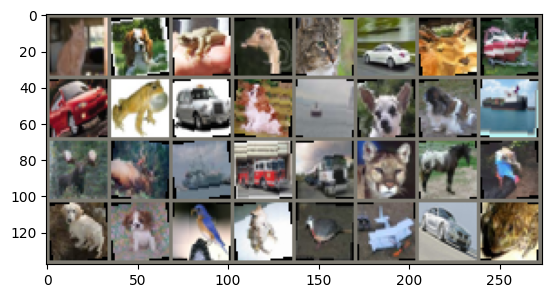

cat  dog  frog bird cat  car  deer ship car  frog car  dog  ship dog  dog  ship deer deer ship trucktruckcat  horsebird dog  dog  bird frog bird planecar  frog 


In [ ]:
def imshow(img):
  mean = torch.Tensor([0.49139968, 0.48215827 ,0.44653124]).view(3,1,1)
  std = torch.Tensor([0.24703233, 0.24348505, 0.26158768]).view(3,1,1)


  img = img * std + mean
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

dataiter= iter(train_loader)
images, labels = next(dataiter)
# images = images.numpy()

# fig = plt.figure(figsize=(25,4))

imshow(make_grid(images))

print(''.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

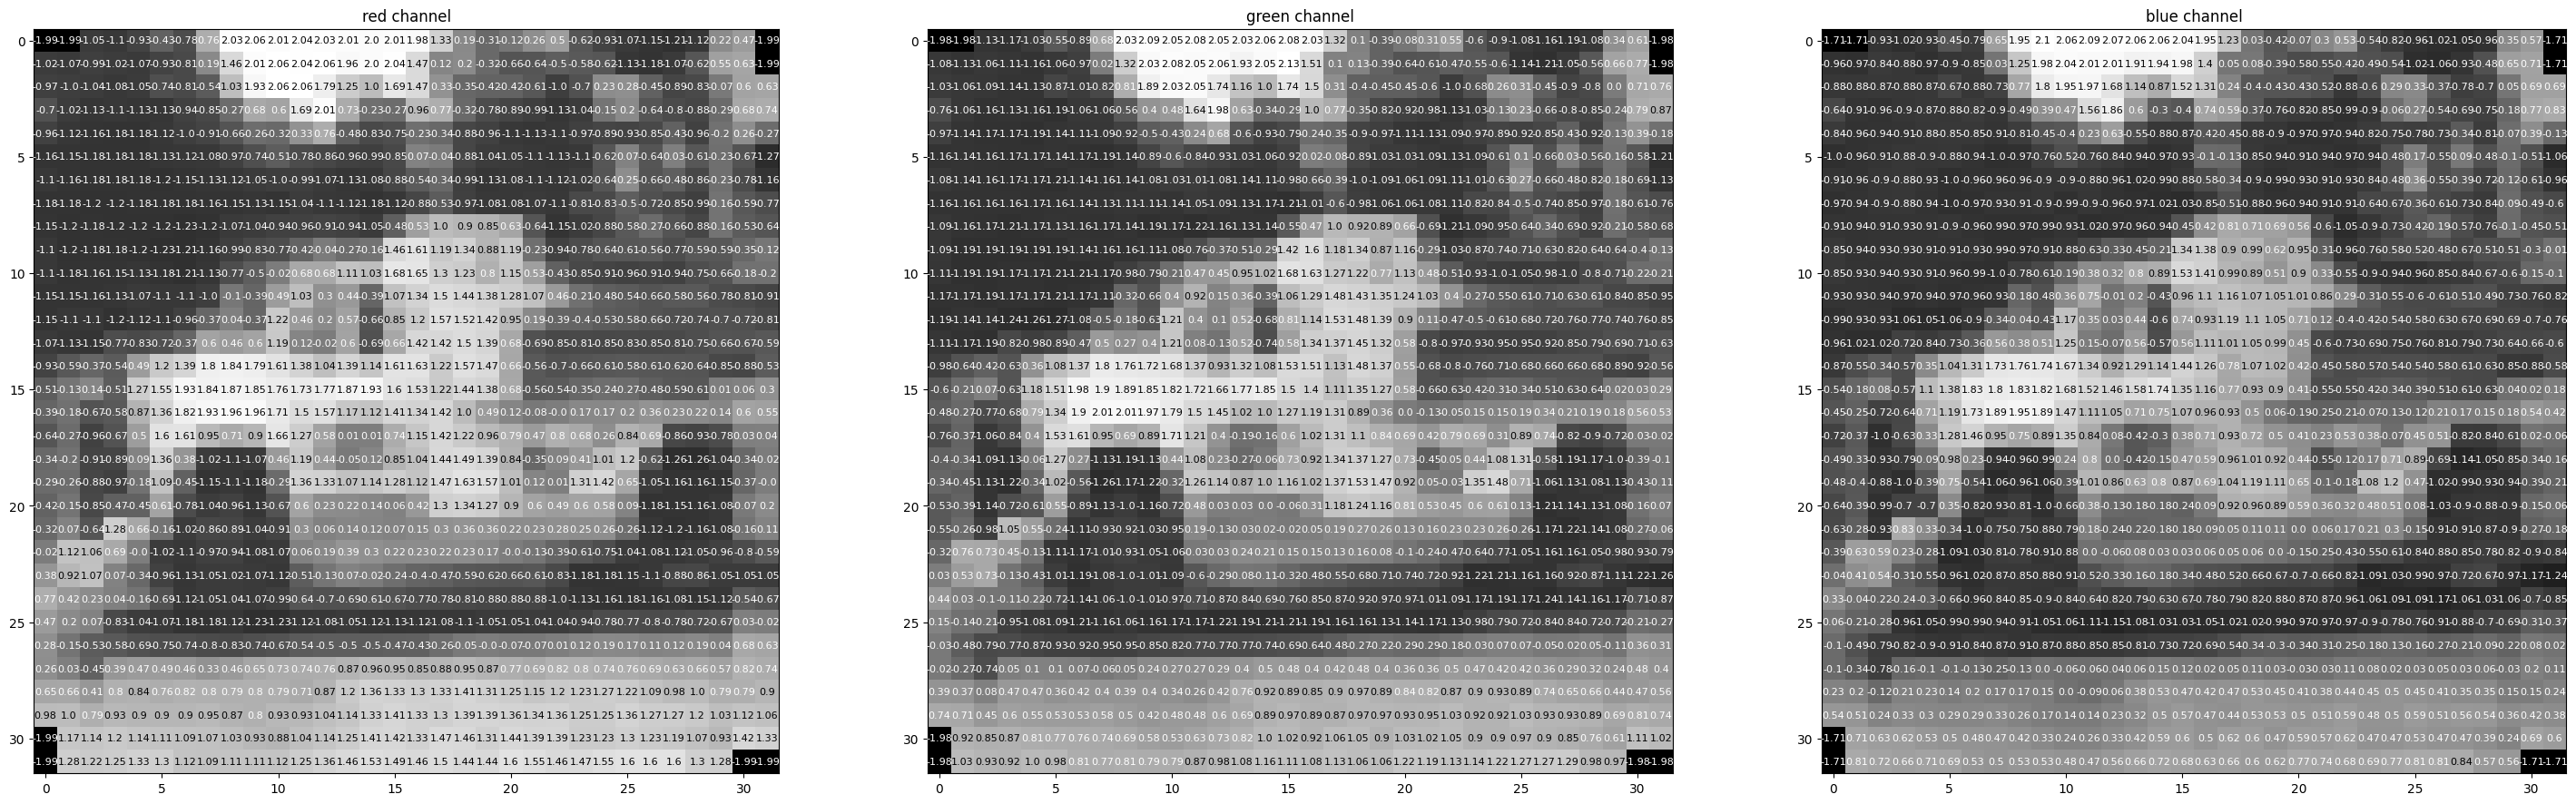

In [ ]:
rgb_img = np.squeeze(images[8])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [ ]:
class CNNNet(nn.Module):
  def __init__(self):
    super(CNNNet, self).__init__()

    # self.relu = F.relu()
    self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

    self.pool = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(64*4*4, 500)

    self.fc2 = nn.Linear(500, 10)

    self.dropout= nn.Dropout(0.25)


  def forward(self, x):
    x= self.pool(F.relu(self.conv1(x)))   # 32*32*3 => w,h = (w,h+2p-k)/s+1 = (32+2-3)/1+1=32 = 32*32*16--> maxpool(2,2) = 16*16*16
    x= self.pool(F.relu(self.conv2(x)))   # 16*16*32 => 8*8*32
    x= self.pool(F.relu(self.conv3(x)))   # 8*8*64 => 4*4*64 --> the input of linear layer

    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    # x = F.softmax(x, dim=1)

    return x



In [ ]:
model= CNNNet()
print(model)

CNNNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
model.to(device)


CNNNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
lr = 0.002
momentum = 0.9
weight_decay = 0.01

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum, ) #weight_decay= weight_decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
saved_dir = '../output/saved_model_2'
os.makedirs(saved_dir, exist_ok=True)

In [ ]:
# model.load_state_dict(torch.load('../output/saved_model_1/model_epoch_15.pth', map_location=torch.device('cpu')))   #

In [ ]:

n_epochs = 50

for epoch in range(n_epochs+1):
  train_loss = 0.0
  valid_loss = 0.0

  model.train()

  for data, target in train_loader:
    # data = data.to(device)
    # target = target.to(device)

    output = model(data)
    optimizer.zero_grad()


    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()*data.size(0)

  # scheduler.step()


  # Validate the model
  model.eval()
  for data, target in valid_loader:
    # data, target = data.to(device), target.to(device)

    output= model(data)
    loss = criterion(output, target)
    valid_loss += loss.item() * data.size(0)

  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

  if (epoch+1) % 5 == 0:
    filename = f'model_epoch_{epoch+1}.pth'
    model_path = os.path.join(saved_dir, filename)
    torch.save(model.state_dict(),  model_path)
    print(f'******** Model saved in {model_path} ***********')



Epoch: 0 	Training Loss: 1.662643 	Validation Loss: 0.360143
Epoch: 1 	Training Loss: 1.356524 	Validation Loss: 0.307062
Epoch: 2 	Training Loss: 1.215842 	Validation Loss: 0.280498
Epoch: 3 	Training Loss: 1.133570 	Validation Loss: 0.262711
Epoch: 4 	Training Loss: 1.066995 	Validation Loss: 0.246700
******** Model saved in ../output/saved_model_2/model_epoch_5.pth ***********
Epoch: 5 	Training Loss: 1.019463 	Validation Loss: 0.236871
Epoch: 6 	Training Loss: 0.974038 	Validation Loss: 0.224292
Epoch: 7 	Training Loss: 0.939022 	Validation Loss: 0.217974
Epoch: 8 	Training Loss: 0.893951 	Validation Loss: 0.206989
Epoch: 9 	Training Loss: 0.864801 	Validation Loss: 0.205522
******** Model saved in ../output/saved_model_2/model_epoch_10.pth ***********
Epoch: 10 	Training Loss: 0.842247 	Validation Loss: 0.193220
Epoch: 11 	Training Loss: 0.816502 	Validation Loss: 0.189298
Epoch: 12 	Training Loss: 0.791581 	Validation Loss: 0.186779
Epoch: 13 	Training Loss: 0.775977 	Validation 

In [ ]:
model.load_state_dict(torch.load('../output/saved_model_2/model_epoch_50.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
n_epochs = 100

for epoch in range(50, n_epochs+1):
  train_loss = 0.0
  valid_loss = 0.0

  model.train()

  for data, target in train_loader:
    # data = data.to(device)
    # target = target.to(device)

    output = model(data)
    optimizer.zero_grad()


    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()*data.size(0)

  scheduler.step()

  # Validate the model
  model.eval()
  for data, target in valid_loader:
    # data, target = data.to(device), target.to(device)

    output= model(data)
    loss = criterion(output, target)
    valid_loss += loss.item() * data.size(0)

  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

  if (epoch+1) % 5 == 0:
    filename = f'model_epoch_{epoch+1}.pth'
    model_path = os.path.join(saved_dir, filename)
    torch.save(model.state_dict(),  model_path)
    print(f'******** Model saved in {model_path} ***********')

Epoch: 50 	Training Loss: 0.437894 	Validation Loss: 0.126622
Epoch: 51 	Training Loss: 0.440641 	Validation Loss: 0.125763
Epoch: 52 	Training Loss: 0.427587 	Validation Loss: 0.129128
Epoch: 53 	Training Loss: 0.430176 	Validation Loss: 0.122628
Epoch: 54 	Training Loss: 0.427174 	Validation Loss: 0.127251
******** Model saved in ../output/saved_model_2/model_epoch_55.pth ***********
Epoch: 55 	Training Loss: 0.422241 	Validation Loss: 0.123401
Epoch: 56 	Training Loss: 0.419196 	Validation Loss: 0.124951
Epoch: 57 	Training Loss: 0.413409 	Validation Loss: 0.127420
Epoch: 58 	Training Loss: 0.408958 	Validation Loss: 0.124113
Epoch: 59 	Training Loss: 0.404236 	Validation Loss: 0.123858
******** Model saved in ../output/saved_model_2/model_epoch_60.pth ***********
Epoch: 60 	Training Loss: 0.370110 	Validation Loss: 0.119873
Epoch: 61 	Training Loss: 0.364544 	Validation Loss: 0.118999
Epoch: 62 	Training Loss: 0.363280 	Validation Loss: 0.120004
Epoch: 63 	Training Loss: 0.358880 	

In [ ]:
model.load_state_dict(torch.load('../output/saved_model_2/model_epoch_100.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # images, labels = images.to(device) , labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 80 %


In [ ]:
transforms = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])


predicted class:  bird



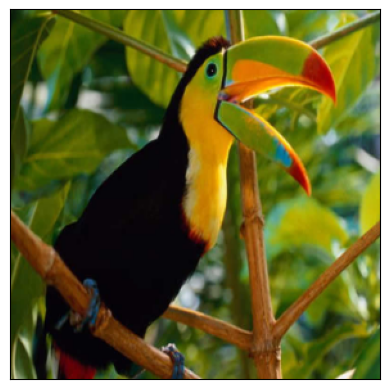

In [ ]:
img = Image.open('../input/bird.png')
img_tensor = transforms(img)

# Add batch dimension
img_tensor = torch.unsqueeze(img_tensor, 0)
model.eval()

output = model(img_tensor)
_, predicted = torch.max(output.data, 1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
class_name = classes[predicted.item()]
print('predicted class: ', class_name)
print('')

predicted class:  plane



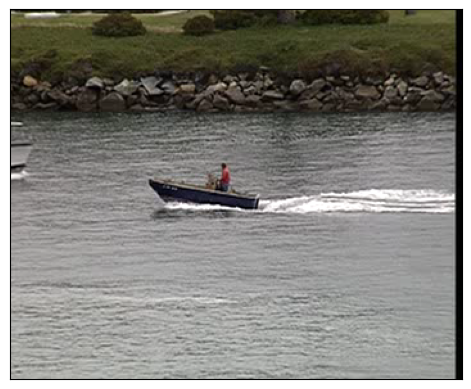

In [ ]:
img = Image.open('../input/coastguard.png')
img_tensor = transforms(img)

# Add batch dimension
img_tensor = torch.unsqueeze(img_tensor, 0)
model.eval()

output = model(img_tensor)
_, predicted = torch.max(output.data, 1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
class_name = classes[predicted.item()]
print('predicted class: ', class_name)
print('')